# Run a NF Experiment, II

In [1]:
import time
import matplotlib
import sys
import scipy
import numpy as np
import easygui
import matplotlib.pyplot as plt
import mne
from IPython.display import clear_output
import re
import pickle
import dynarray
import random

import logging  # set log level
logging.basicConfig(level=logging.WARNING)

sys.path.append("../../mushu")  # driver for the amps
sys.path.append("../../mushu/libmushu")
import libmushu

sys.path.append("../../callpyff")   # talk to the stimuli
from callpyff import bcinetwork, bcixml 

sys.path.append("../../nftools")  # handy stuff needed for NF
from nftools.loopcontrol import LoopState
from nftools.analysis import convert_alld_allm_to_mne
from nftools.analysis import select_part_from_mne_dataset
from nftools.analysis import plot_compare_two_spectra
from nftools import camera

sys.path.append("../../wyrm")  # real-time data analysis
from wyrm.types import RingBuffer
from wyrm.types import BlockBuffer
from wyrm import io
from wyrm import processing as proc
from scipy import signal

In [2]:
# setup my filters for real-time data filtering: HP Filter

fs=5000.
f_low = 1.0
# f_high = 15.0
butter_ord = 3
lenchannels = 64

#rt_b, rt_a = signal.butter(butter_ord, [f_low / fn, f_high / fn], btype='band')
rt_b_hp, rt_a_hp = signal.butter(butter_ord, 2*f_low/fs, btype='high', analog=False)  # a digital high-pass filter
rt_zi_hp = proc.lfilter_zi(rt_b_hp, rt_a_hp, lenchannels)


In [3]:
# setup my filters for real-time data filtering: BP Filter


fs=5000.
f_low = 12.0
f_high = 15.0
butter_ord = 3
lenchannels = 64

#rt_b, rt_a = signal.butter(butter_ord, [f_low / fn, f_high / fn], btype='band')
rt_b_bp, rt_a_bp = signal.butter(butter_ord, [2*f_low/fs, 2*f_high/fs], btype='band', analog=False)  # a digital high-pass filter
rt_zi_bp = proc.lfilter_zi(rt_b_bp, rt_a_bp, lenchannels)

In [4]:
import libmushu
amp = libmushu.get_amp('bpamp')

In [5]:
# Configure the amp
amp.configure(remotecontrol=True,
              recorderip='20.100.0.3',
              recorderport=51244,
              pathtoworkspace='C:\\Vision\\Workfiles\\NF_64chEEG.rwksp',
              experimentnumber='Pre-Run01',
              subjectid='0001',
              n_channels=64,
              fs=5000)

connecting to 20.100.0.3 port 6700
sending b'1C:\\Vision\\Workfiles\\NF_64chEEG.rwksp'
sending b'2Pre-Run01'
sending b'30001'
sending b'4'
sending b'M'


In [6]:
bcinet = bcinetwork.BciNetwork('20.100.0.2', bcinetwork.FC_PORT, bcinetwork.GUI_PORT, 'bcixml')

In [7]:
feedbacks = bcinet.getAvailableFeedbacks()
print(feedbacks)

['TestD2', 'MovingRhomb', 'LibetClock', 'TobiQLAdapter', 'Lesson04', 'EyetrackerRawdata', 'EyetrackerFeedback', 'HexoSpeller', 'P300_Rectangle', 'ERPHex', 'BrainWaveTraining', 'FeedbackCursorArrow', 'TrivialPong', 'CheckerboardVEP', 'HexoSpellerVE', 'BoringClock', 'nback_verbal', 'Lesson01', 'BrainPong', 'CakeSpellerVE', 'MovingRhombGL', 'NFBasicThermometer', 'RSVPSpeller', 'CenterSpellerVE', 'MultiVisualOddball', 'Lesson01b', 'GoalKeeper', 'EEGfMRILocalizer', 'Oddball', 'StroopFeedback', 'ERPMatrix', 'VisualOddballVE', 'Lesson05', 'Lesson06', 'VisualOddball', 'Lesson02', 'Lesson03']


In [8]:
bcinet.send_init('BrainWaveTraining')

In [10]:
bcinet.get_variables()

{'MONITOR_NSCREENS': 2,
 'MONITOR_HEIGHT': 30.0,
 'EX_GRAPHICSMODE': 'line',
 'fontheight': 200,
 'EX_SQUARESIZE': 0.25,
 'color': [0, 0, 0],
 'MONITOR_DEGS_WIDTHBASE': 12,
 'MONITOR_FLIPVERTICAL': False,
 'EVENT_printToTerminalAllowed': [0, 255],
 'udp_markers_port': 12344,
 'MONITOR_USEDEGS': True,
 'MONITOR_ALLOWGUI': False,
 'EX_TUNING_PARAMS': [1.0, 0.0],
 'MONITOR_DISPLAYONSCREEN': 1,
 'EVENT_sendParallel': True,
 'EX_NUMBEROFSETS': 6,
 'EX_INTERACTIONMODE': 'master',
 'EX_NREGULATE': 30,
 'MONITOR_DEGS_HEIGHTBASE': 10,
 'udp_markers_host': '127.0.0.1',
 'EX_TESTNFNOISE': True,
 'CP': {'WIN_CONDITION': 'time_above_thr',
  'CURRENTPART': [None],
  'instruction': 'arrowup',
  'nfsignalContainer': [0],
  'TUNING_TYPE': 'thr',
  'TJITT': [1],
  'corr_incorr': [None],
  'TrialType': [None],
  'WIN_PARAMS': [0.25],
  'TUNING_PARAMS': [1.0, 0.0],
  'thrContainer': [0.5]},
 'EX_XorV_RESET_POINTS': False,
 'EVENT_TRIGLOG': 'log/triggerlog.log',
 'EX_BUTTONS': ['lctrl', 'rctrl'],
 'MONITOR

In [11]:
bcinet.send_signal(bcixml.BciSignal({'EX_TESTNFNOISE': False},None, bcixml.INTERACTION_SIGNAL))

In [12]:
bcinet.play()

In [13]:
# camera
c=camera.DoCamera(); c.start()

In [28]:
amp.start()

Number of channels: 64
Sampling interval: 200.0
Resolutions: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 10.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Channel Names: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'POz', 'ECG', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'FT9', 'FT10', 'Fpz', 'CPz']
hdr SamplingInterval = 200.00
FLIPPING/GOING THE THE MIDDLE AGAIN
FLIPPING/GOING THE THE MIDDLE AGAIN
FLIPPING/GOING THE THE MIDDLE AGAIN
FLIPPING/GOING THE THE MIDDLE AGAIN


In [29]:
alld=dynarray.DynamicArray((None, len(amp.get_channels())))     # data
allm=[]     # markers
sfreq = 5000 # amp.get_sampling_frequency()  # sampling frequency
ch_names=['ch %d' % i for i in range(64)] # amp.get_channels()  # channel names

markTime=time.time()
updateTime = 0.01  # run some kind of calculation every X seconds
buffSize = 1.0  # run calculation on last X seconds of data


rb = RingBuffer(buffSize * 1000) # must be specified in msec!
# totalTime = seed_d.shape[0]/raw_fromfile.info['sfreq']

In [30]:
data, marker, annotations = amp.get_data()
data.shape

(1200, 64)

In [31]:
l=LoopState(); l.start()
markeroffset = 0  # needed to store all data in one big mat/vector
t0=time.time()
curTime=time.time()
featureVector=[]

while l.get_state() != 'Stop':
   
    
    # keep track of time:
    curTime = time.time()
    
    # this is where you get the data
    data, marker, annotations = amp.get_data()
    
    if data.shape[0] > 0:  # this is crucual for remembering filter state.
        

        

        # start processing the signal: first convert it to pandas-line array
        cnt = io.convert_mushu_data(data, marker, sfreq, ch_names)

        # then bandpass filter it - this needs to be done continuously
        f_cnt, rt_zi_bp = proc.lfilter(cnt, rt_b_bp, rt_a_bp, zi=rt_zi_bp)  # real-time data preprocessing...

        # a placeholder (currently unused)
        newsamples = cnt.data.shape[0]

        # append to the ringbuffer - this is always "Last 1000 msec of Data"
        rb.append(f_cnt)
        
        # append it to the big matrix --> this is just to store it later on and doesn't do anything
        # related to NF
        alld.extend(data)
        for m in marker:
            allm.append([m[0] + markeroffset, m[1]])
        markeroffset += newsamples / float(sfreq) * 1000.


        # do the following every 0.1 msec - with with the ringbuffer:
        if curTime - markTime > updateTime:

            markTime = curTime

            # obtain data from the ringbuffer - so d is a numpy array.
            d = rb.get()

            plt.plot(d.data[:,3])
            plt.show()
            
            # it's already filtered - so just take the av. power of channel with index 3:
            feature = np.log10(np.mean(abs(d.data[:,3]))) * 10
            featureVector.append(feature)

            # we send the value to BCI/STIM
            featureMax = 0
            featureMin = -6.0
            featureScaling = 1/abs(featureMax - featureMin)
            featureOffset = (featureMax + featureMin) / 2
            signalToSend = featureScaling * (feature - featureOffset)
            bcinet.send_signal(bcixml.BciSignal({'nfsignal': signalToSend},None, bcixml.CONTROL_SIGNAL))
            

            clear_output(wait=True)  # write some logging information here
            print('Data is coming in - time = %f' % (curTime - t0))
            print('Length Markers: %d' % len(allm))
            print('Feature Value: %f' % feature)
            print('Scaled Signal for NF: %f' % signalToSend)
            print(data.shape)





Data is coming in - time = 421.994818
Length Markers: 335
Feature Value: -0.529133
Scaled Signal for NF: 0.411811
(700, 64)
loop is stopped!


In [32]:
amp.stop()

amplifier stopped!


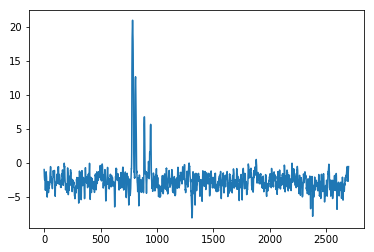

In [33]:
plt.plot(featureVector)

In [34]:
ch_names=amp.get_channels()
alld.shrink_to_fit()

In [35]:
# write to disk, so we can re-load it later:

t={'alld':alld, 'allm':allm, 'ch_names':ch_names, 'sfreq':sfreq}
with open('c-allm-and-alld.pkl', 'wb') as f:
    pickle.dump(t, f)

In [29]:
# load from disk:

with open('c-allm-and-alld.pkl','rb') as f:
    t=pickle.load(f)
for key in t.keys():
    locals()[key] = t[key]

In [36]:
alld.shape

(2112600, 64)

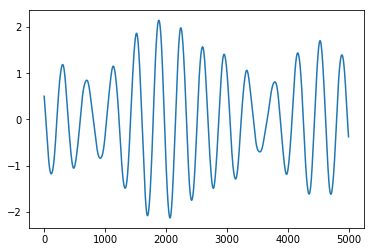

In [37]:
plt.figure()
plt.plot(d.data[:,3])

In [39]:
raw = convert_alld_allm_to_mne(alld, allm, ch_names, sfreq)  # covert to MNE
raw.resample(1000)

The following EEG sensors did not have a position specified in the selected montage: ['ECG']. Their position has been left untouched.


../../nftools/nftools/analysis.py:31: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['ECG']. Their position has been left untouched.
  montage=montage


Creating RawArray with float64 data, n_channels=64, n_times=2112600
    Range : 0 ... 2112599 =      0.000 ...   422.520 secs
Ready.
5000.0
Creating RawArray with float64 data, n_channels=1, n_times=2112600
    Range : 0 ... 2112599 =      0.000 ...   422.520 secs
Ready.
335 events found
Event IDs: [  1   2   3   4   5   6  11  12  13  14  15  21  22  23  25  26  31  32
  33  34  35  36  41  42  43  44  45  46 150 151 159 160 161 169]
335 events found
Event IDs: [  1   2   3   4   5   6  11  12  13  14  15  21  22  23  25  26  31  32
  33  34  35  36  41  42  43  44  45  46 150 151 159 160 161 169]


<RawArray  |  None, n_channels x n_times : 65 x 422520 (422.5 sec), ~209.7 MB, data loaded>

In [40]:
% matplotlib qt5

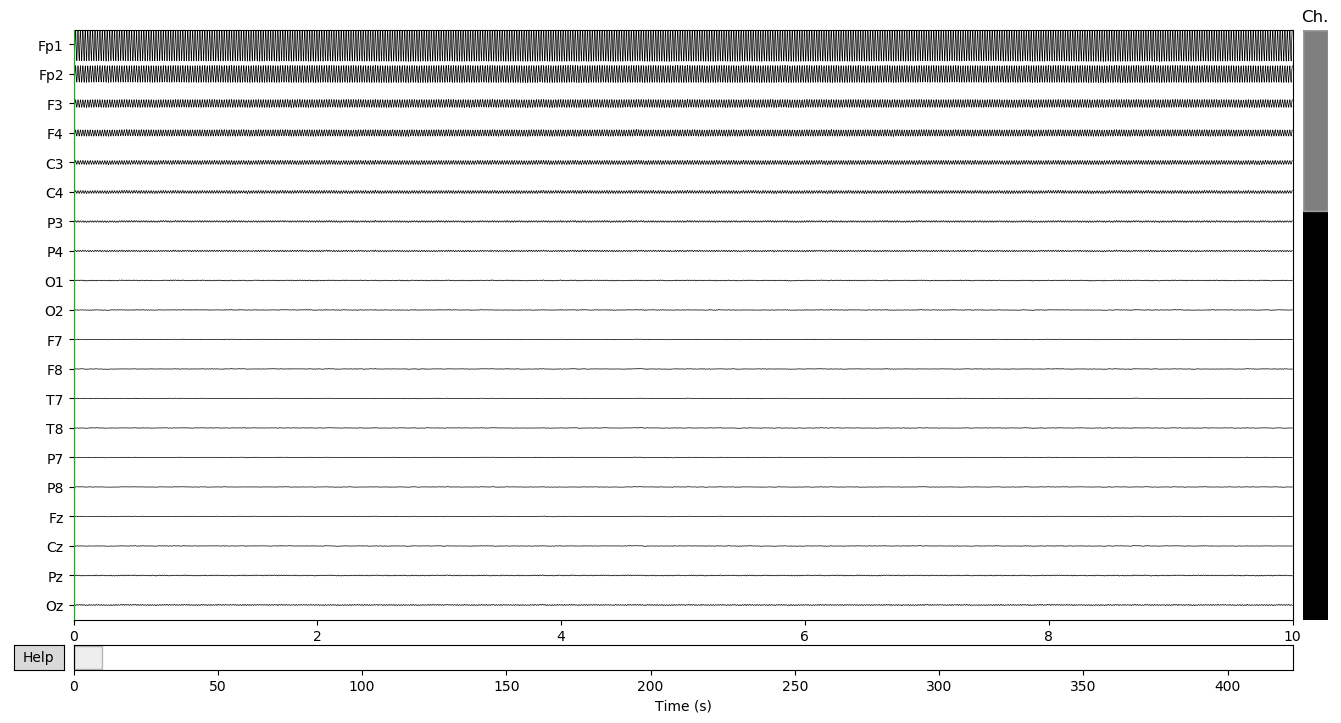

In [41]:
raw.plot(scalings='auto')